In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nail-disease-detection-dataset/data/validation/blue_finger/Screen-Shot-2021-10-15-at-10-44-09-AM_png.rf.fa5059ea7a03fc7853fa574ce5b05a59.jpg
/kaggle/input/nail-disease-detection-dataset/data/validation/blue_finger/Screen-Shot-2021-10-15-at-10-40-07-AM_png.rf.ce1377336d3cfe8a5956c7822d0f3536.jpg
/kaggle/input/nail-disease-detection-dataset/data/validation/blue_finger/Screen-Shot-2021-10-15-at-10-43-24-AM_png.rf.d7cfd2a2eb508c0cf55d67a6e482e83f.jpg
/kaggle/input/nail-disease-detection-dataset/data/validation/blue_finger/Screen-Shot-2021-10-15-at-10-44-24-AM_png.rf.0fc15e7d1ca7e1dd1009010d21c4b025.jpg
/kaggle/input/nail-disease-detection-dataset/data/validation/blue_finger/Screen-Shot-2021-10-15-at-10-44-09-AM_png.rf.9196975a777207fee17ee744f60d81b3.jpg
/kaggle/input/nail-disease-detection-dataset/data/validation/blue_finger/Screen-Shot-2021-10-15-at-10-41-24-AM_png.rf.79aabe37924d244e8c96e49f030e57bf.jpg
/kaggle/input/nail-disease-detection-dataset/data/validation/blue_fing

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import OrderedDict
import pandas as pd

# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [3]:

# ===========================
# DATA LOADING & PREPROCESSING
# ===========================

train_dir = '/kaggle/input/nail-disease-detection-dataset/data/train'
valid_dir = '/kaggle/input/nail-disease-detection-dataset/data/validation'

# Data transformations 
data_transforms = {
    'training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                           [0.229, 0.224, 0.225])
    ]),
    
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                           [0.229, 0.224, 0.225])
    ]),
    
    'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                           [0.229, 0.224, 0.225])
    ])
}

batch_size = 32

# Create datasets
image_datasets = {
    'training': datasets.ImageFolder(train_dir, transform=data_transforms['training']),
    'validation': datasets.ImageFolder(valid_dir, transform=data_transforms['validation'])
}

dataloaders = {
    'training': torch.utils.data.DataLoader(
        image_datasets['training'],
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,      # NEW: Parallel data loading
        pin_memory=True     # NEW: Faster GPU transfer
    ),
    'validation': torch.utils.data.DataLoader(
        image_datasets['validation'],
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,      # NEW
        pin_memory=True     # NEW
    )
}

# Get lengths and class information
training_len = len(dataloaders['training'])
validation_len = len(dataloaders['validation'])
class_to_idx = image_datasets['training'].class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)

print(f'We have {training_len} batches of training images; each with {batch_size} images')
print(f'We have {validation_len} batches of validation images; each with {batch_size} images')
print(f'Number of classes: {num_classes}')
print(f'Classes: {list(class_to_idx.keys())}')
print(f'\nSingle batch shape: {next(iter(dataloaders["training"]))[0].shape}')


We have 117 batches of training images; each with 32 images
We have 3 batches of validation images; each with 32 images
Number of classes: 6
Classes: ['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis', 'blue_finger', 'clubbing', 'pitting']

Single batch shape: torch.Size([32, 3, 224, 224])


In [4]:
# ===========================
# MODEL SETUP (DenseNet201)
# ===========================

from torchvision import models
from torch import nn
from collections import OrderedDict

# Load pre-trained DenseNet201
model = models.densenet201(pretrained=True)

# Freeze all parameters in the feature extractor
for param in model.parameters():
    param.requires_grad = False

print("\nOriginal DenseNet201 classifier:")
print(model.classifier)

# Define custom classifier
# DenseNet201 feature output size = 1920
hidden_units = 1024

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1920, hidden_units)),  # DenseNet201 features output 1920
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.5)),
    ('fc2', nn.Linear(hidden_units, 512)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(0.3)),
    ('fc3', nn.Linear(512, num_classes)),
    ('output', nn.LogSoftmax(dim=1))
]))

# Replace the original classifier
model.classifier = classifier

print("\nNew custom classifier:")
print(model.classifier)

# Move model to device (GPU/CPU)
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 240MB/s]



Original DenseNet201 classifier:
Linear(in_features=1920, out_features=1000, bias=True)

New custom classifier:
Sequential(
  (fc1): Linear(in_features=1920, out_features=1024, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=512, out_features=6, bias=True)
  (output): LogSoftmax(dim=1)
)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu


STARTING TRAINING - DenseNet Model
Epoch 0, Batch 0 - Loss: 0.7951, Acc: 0.6875
Epoch 0, Batch 20 - Loss: 0.9982, Acc: 0.5312
Epoch 0, Batch 40 - Loss: 0.7079, Acc: 0.6250
Epoch 0, Batch 60 - Loss: 0.7290, Acc: 0.6875
Epoch 0, Batch 80 - Loss: 0.9179, Acc: 0.5938
Epoch 0, Batch 100 - Loss: 1.2618, Acc: 0.6250
  ✓ New best DenseNet model saved!

Epoch 0 Summary:
  Avg training loss: 0.7889
  Avg training accuracy: 0.6979 (69.79%)
  Avg validation loss: 0.3919
  Avg validation accuracy: 0.8920 (89.20%)

Epoch 1, Batch 0 - Loss: 0.8032, Acc: 0.6875
Epoch 1, Batch 20 - Loss: 1.0318, Acc: 0.7188
Epoch 1, Batch 40 - Loss: 0.7834, Acc: 0.7500
Epoch 1, Batch 60 - Loss: 0.8743, Acc: 0.6562
Epoch 1, Batch 80 - Loss: 0.8166, Acc: 0.6875
Epoch 1, Batch 100 - Loss: 0.7102, Acc: 0.6875

Epoch 1 Summary:
  Avg training loss: 0.8050
  Avg training accuracy: 0.6934 (69.34%)
  Avg validation loss: 0.4252
  Avg validation accuracy: 0.7743 (77.43%)

Epoch 2, Batch 0 - Loss: 0.6786, Acc: 0.8125
Epoch 2, B

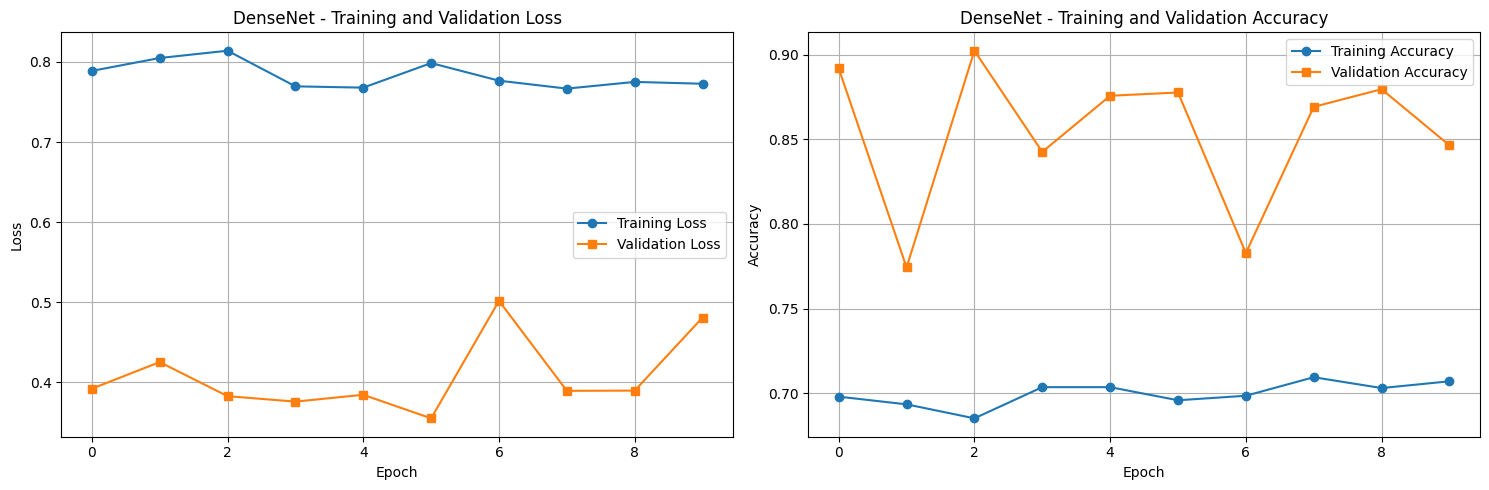


DETAILED MODEL EVALUATION - DenseNet

Overall Accuracy: 0.8462 (84.62%)

------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma     0.7083    0.9444    0.8095        18
              Healthy_Nail     1.0000    1.0000    1.0000        20
           Onychogryphosis     1.0000    0.5000    0.6667        12
               blue_finger     0.6667    0.8889    0.7619         9
                  clubbing     1.0000    0.6250    0.7692        16
                   pitting     0.8421    1.0000    0.9143        16

                  accuracy                         0.8462        91
                 macro avg     0.8695    0.8264    0.8203        91
              weighted avg     0.8816    0.8462    0.8392        91


------------------------------------------------------------
AGGREGATE METRICS
-------------------

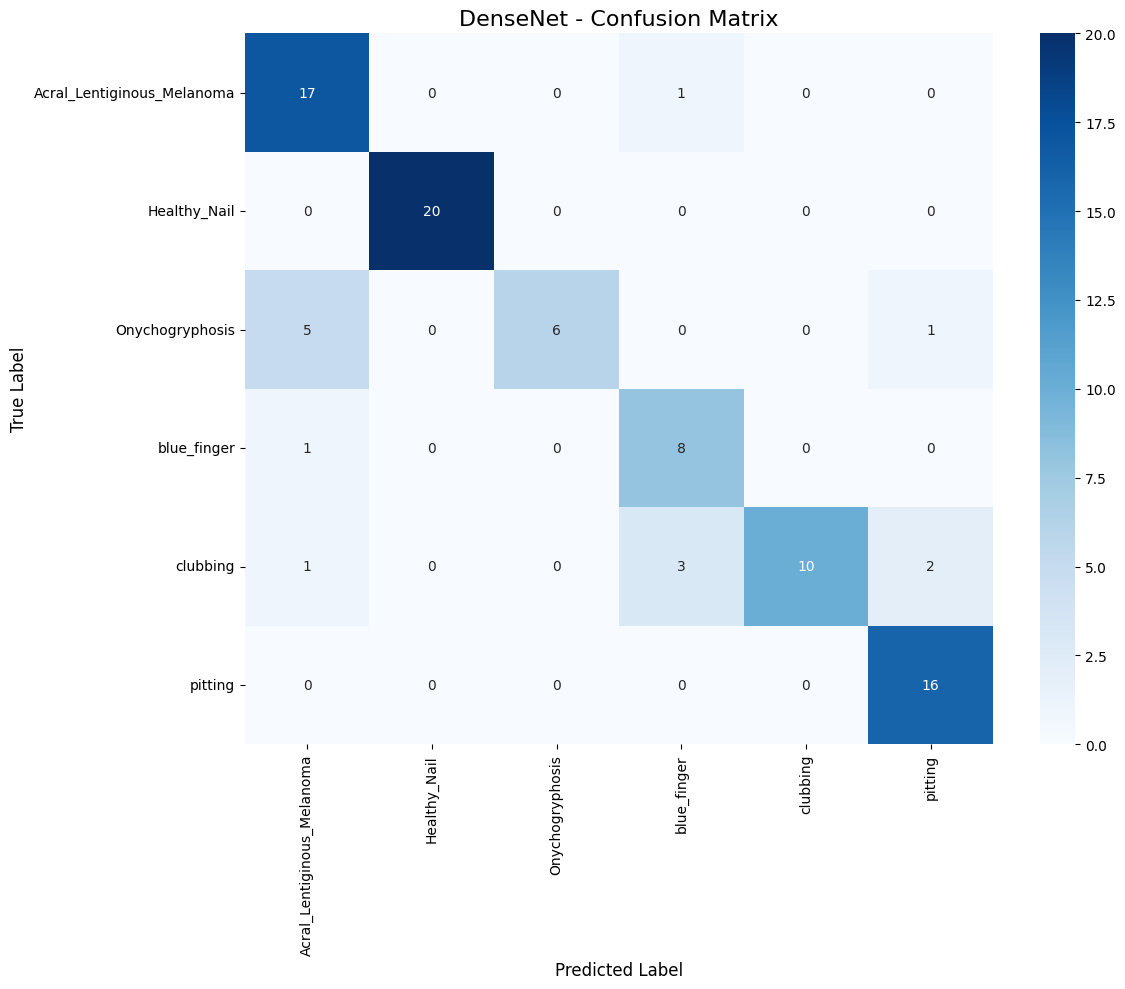

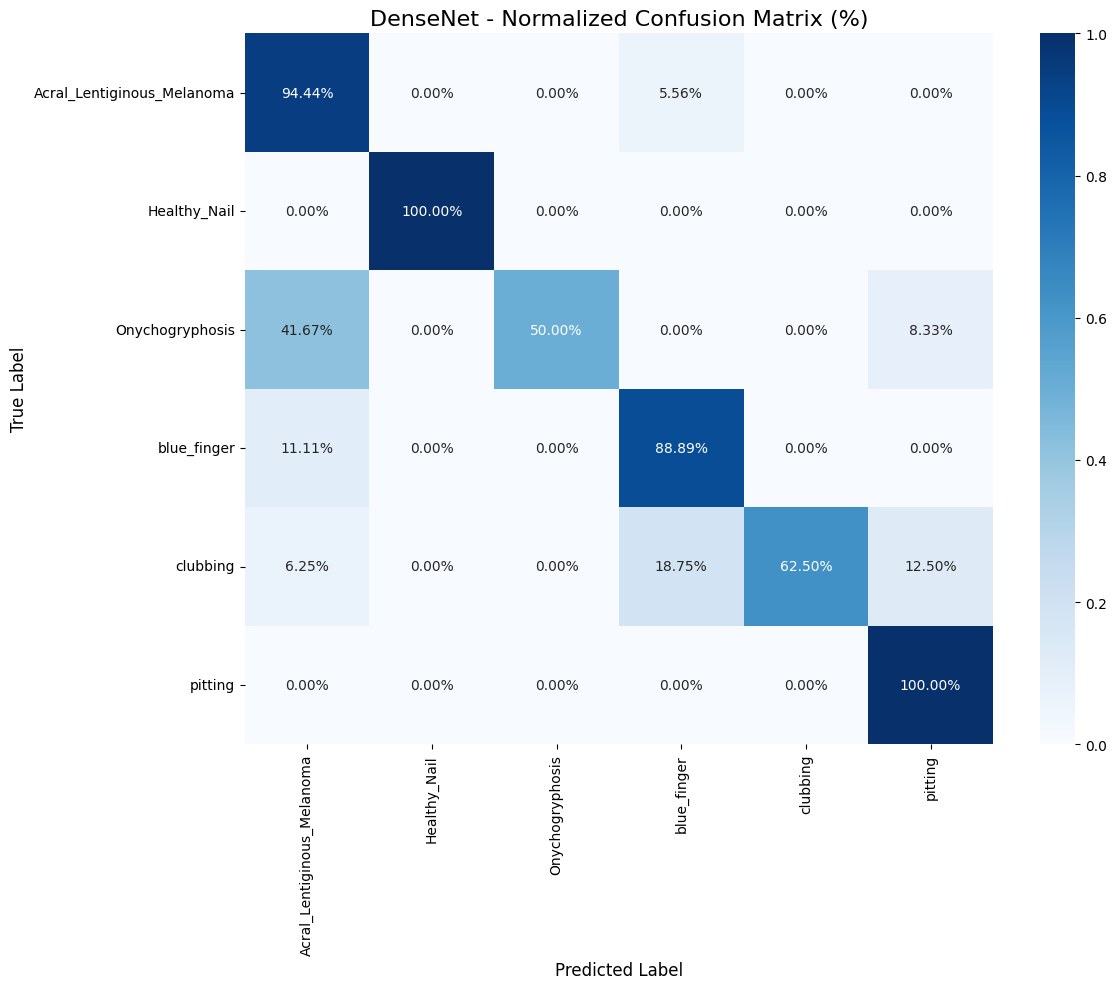

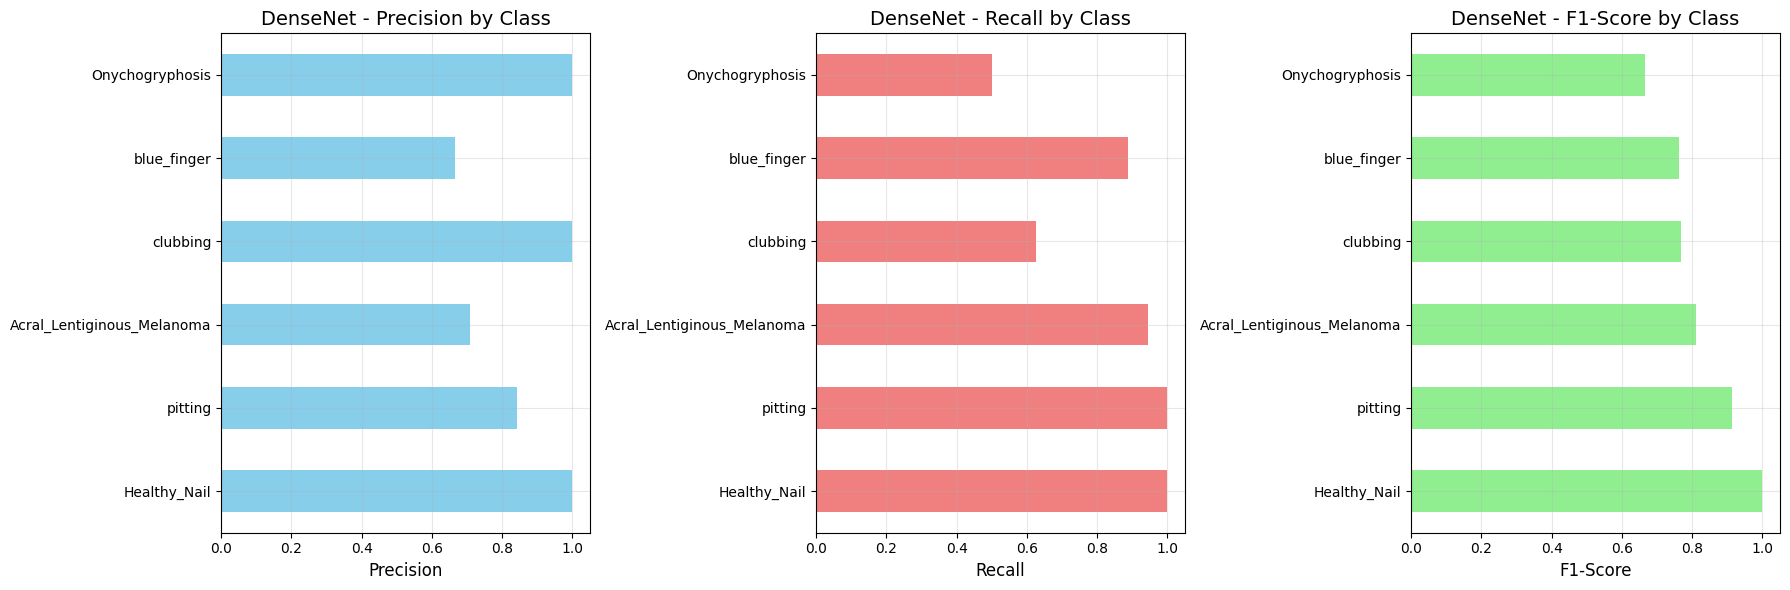


------------------------------------------------------------
SAMPLE PREDICTIONS - DenseNet
------------------------------------------------------------


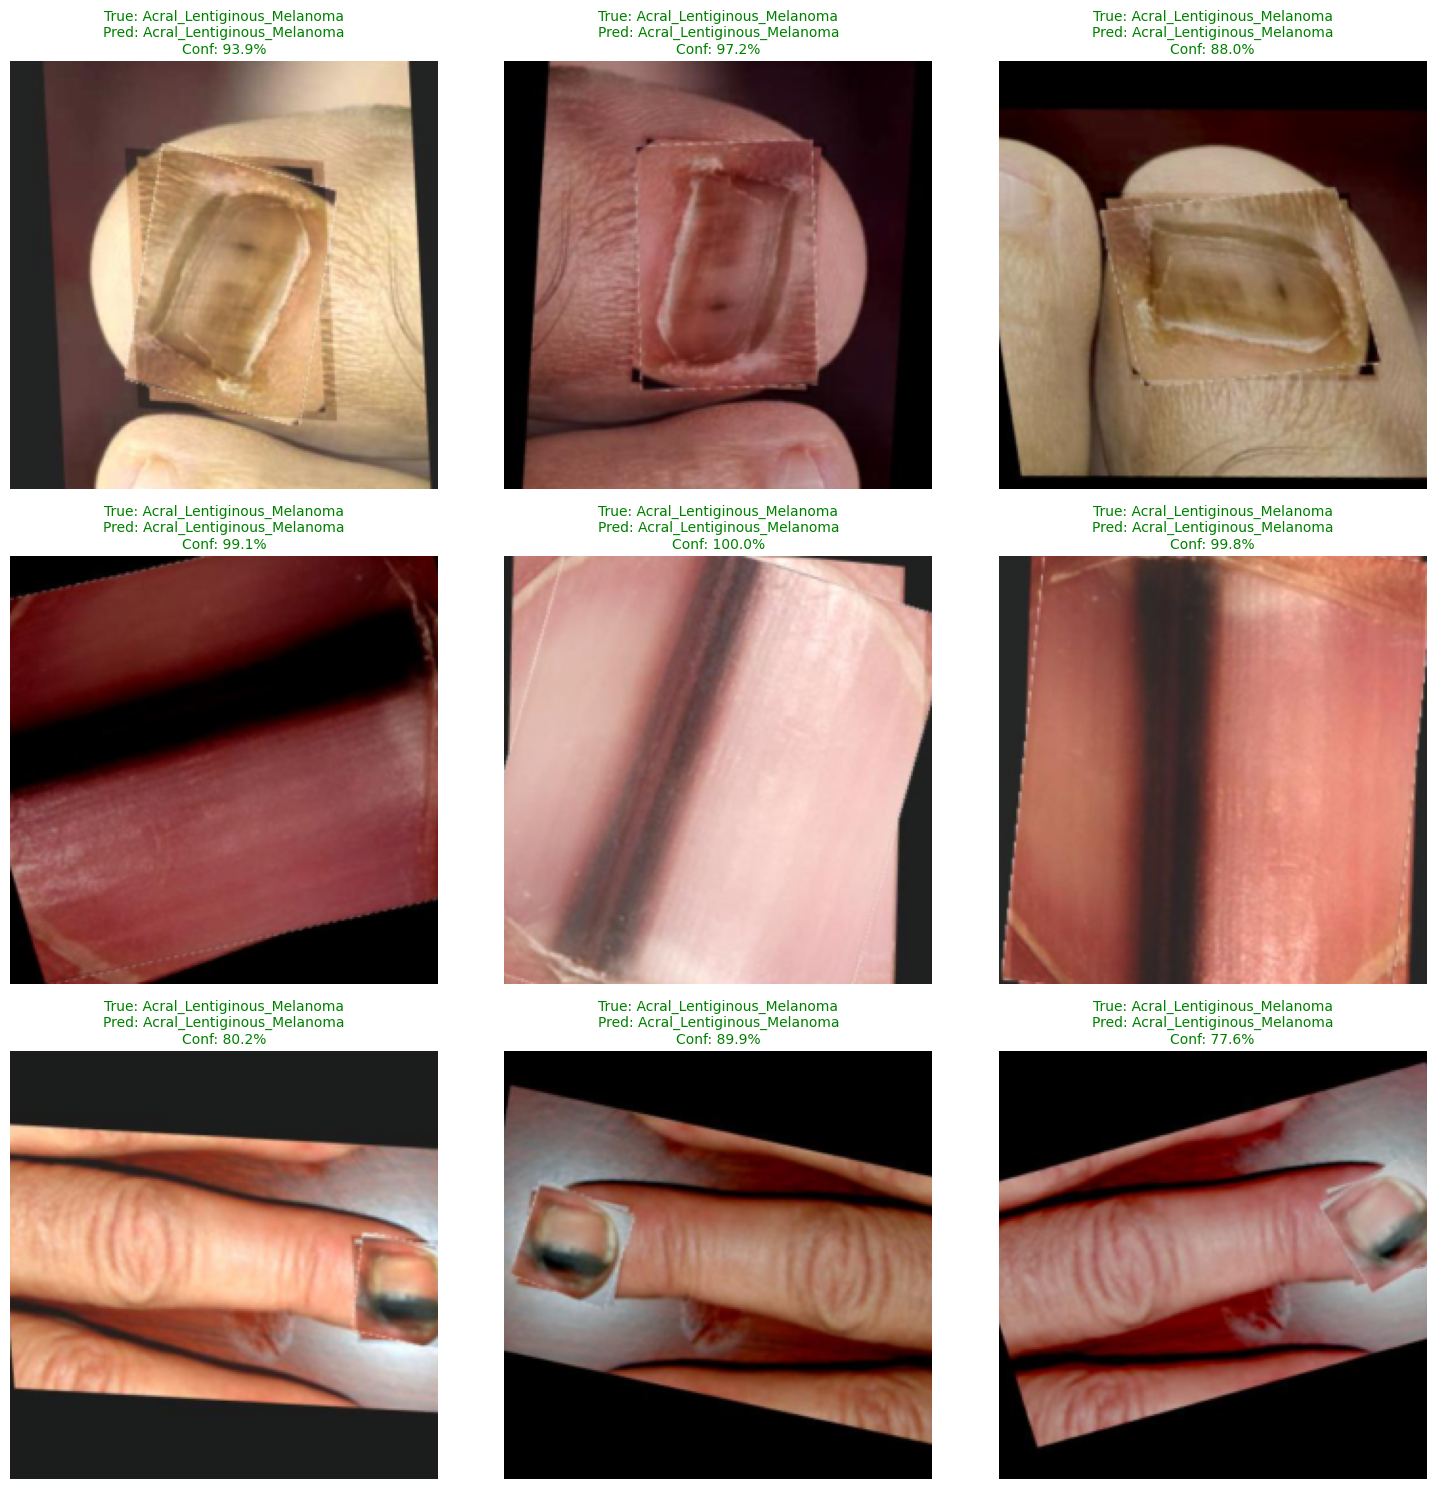


DenseNet model checkpoint saved as 'densenet_nail_disease_best.pth'
Download from: Output tab (right sidebar)
DenseNet model weights saved as 'densenet_nail_disease_weights.pth'

TRAINING AND EVALUATION COMPLETE!


In [6]:
# ===========================
# TRAINING SETUP
# ===========================

epochs = 10
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.NLLLoss()
print_every = 20 

validation_accuracies, training_accuracies = [], []
validation_losses, training_losses = [], []

best_validation_accuracy = 0
best_model_weights = None

print("\n" + "="*60)
print("STARTING TRAINING - DenseNet Model")
print("="*60)

# ===========================
# TRAINING LOOP
# ===========================

import time
start_time = time.time()

for e in range(epochs):
    
    training_loss = training_accuracy = 0
    validation_loss = validation_accuracy = 0
    
    # ===== TRAINING PHASE =====
    model.train()
    for batch_idx, (images, labels) in enumerate(dataloaders['training']):
        
        # Move to device
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
        train_batch_accuracy = matches.mean()
        
        # Track metrics
        training_loss += loss.item()
        train_batch_loss = loss.item()
        training_accuracy += train_batch_accuracy.item()
        
        # Print less frequently for speed
        if batch_idx % print_every == 0:
            print(f'Epoch {e}, Batch {batch_idx} - Loss: {train_batch_loss:.4f}, Acc: {train_batch_accuracy.item():.4f}')
    
    # ===== VALIDATION PHASE =====
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloaders['validation']):
            images, labels = images.to(device), labels.to(device)
            
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            
            ps = torch.exp(log_ps)
            top_ps, top_class = ps.topk(1, dim=1)
            matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
            validation_batch_accuracy = matches.mean()
            
            # Track validation metrics
            validation_loss += loss.item()
            validation_batch_loss = loss.item()
            validation_accuracy += validation_batch_accuracy.item()
    
    # Save best model
    if validation_accuracy >= best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_model_weights = model.state_dict()
        print(f"  ✓ New best DenseNet model saved!")
    
    # Epoch summary
    avg_train_loss = training_loss / training_len
    avg_train_acc = training_accuracy / training_len
    avg_val_loss = validation_loss / validation_len
    avg_val_acc = validation_accuracy / validation_len
    
    print(f'\nEpoch {e} Summary:')
    print(f'  Avg training loss: {avg_train_loss:.4f}')
    print(f'  Avg training accuracy: {avg_train_acc:.4f} ({avg_train_acc*100:.2f}%)')
    print(f'  Avg validation loss: {avg_val_loss:.4f}')
    print(f'  Avg validation accuracy: {avg_val_acc:.4f} ({avg_val_acc*100:.2f}%)')
    print()
    
    training_losses.append(avg_train_loss)
    training_accuracies.append(avg_train_acc)
    validation_losses.append(avg_val_loss)
    validation_accuracies.append(avg_val_acc)

# Load best model weights
model.load_state_dict(best_model_weights)

# Calculate mean best validation accuracy
best_val_acc_mean = best_validation_accuracy / validation_len
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc_mean:.3f} ({best_val_acc_mean*100:.2f}%)")
print("="*60)

# ===========================
# PLOT TRAINING HISTORY
# ===========================

def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs_range = range(len(train_losses))
    
    # Loss plot
    axes[0].plot(epochs_range, train_losses, label='Training Loss', marker='o')
    axes[0].plot(epochs_range, val_losses, label='Validation Loss', marker='s')
    axes[0].set_title('DenseNet - Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy plot
    axes[1].plot(epochs_range, train_accs, label='Training Accuracy', marker='o')
    axes[1].plot(epochs_range, val_accs, label='Validation Accuracy', marker='s')
    axes[1].set_title('DenseNet - Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(training_losses, validation_losses, 
                     training_accuracies, validation_accuracies)

# ===========================
# DETAILED EVALUATION
# ===========================

print("\n" + "="*60)
print("DETAILED MODEL EVALUATION - DenseNet")
print("="*60)

# Get all predictions and true labels
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in dataloaders['validation']:
        images, labels = images.to(device), labels.to(device)
        
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        
        all_preds.extend(top_class.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(ps.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Class names
class_names = [idx_to_class[i] for i in range(num_classes)]

# ===========================
# METRICS
# ===========================

# 1. Overall Accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f"\nOverall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

# 2. Classification Report
print("\n" + "-"*60)
print("CLASSIFICATION REPORT")
print("-"*60)
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# 3. Per-class metrics
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

precision_weighted = precision_score(all_labels, all_preds, average='weighted')
recall_weighted = recall_score(all_labels, all_preds, average='weighted')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print("\n" + "-"*60)
print("AGGREGATE METRICS")
print("-"*60)
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f}")
print(f"\nWeighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1-Score: {f1_weighted:.4f}")

# ===========================
# CONFUSION MATRIX
# ===========================

cm = confusion_matrix(all_labels, all_preds)

# Raw confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('DenseNet - Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('DenseNet - Normalized Confusion Matrix (%)', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# ===========================
# PER-CLASS PERFORMANCE
# ===========================

per_class_metrics = classification_report(all_labels, all_preds,
                                         target_names=class_names,
                                         output_dict=True)

classes_df = pd.DataFrame(per_class_metrics).T[:-3]  # Exclude avg rows
classes_df = classes_df.sort_values('f1-score', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

classes_df['precision'].plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('DenseNet - Precision by Class', fontsize=14)
axes[0].set_xlabel('Precision', fontsize=12)
axes[0].grid(True, alpha=0.3)

classes_df['recall'].plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_title('DenseNet - Recall by Class', fontsize=14)
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].grid(True, alpha=0.3)

classes_df['f1-score'].plot(kind='barh', ax=axes[2], color='lightgreen')
axes[2].set_title('DenseNet - F1-Score by Class', fontsize=14)
axes[2].set_xlabel('F1-Score', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===========================
# SAMPLE PREDICTIONS
# ===========================

def visualize_predictions(dataloader, model, device, num_samples=9):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
    
    images = images.cpu()
    labels = labels.cpu()
    top_class = top_class.cpu()
    top_ps = top_ps.cpu()
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(images))):
        # Denormalize image
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        
        true_label = idx_to_class[labels[i].item()]
        pred_label = idx_to_class[top_class[i].item()]
        confidence = top_ps[i].item() * 100
        
        color = 'green' if labels[i].item() == top_class[i].item() else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                         color=color, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\n" + "-"*60)
print("SAMPLE PREDICTIONS - DenseNet")
print("-"*60)
visualize_predictions(dataloaders['validation'], model, device)

# ===========================
# SAVE MODEL (KAGGLE OUTPUT)
# ===========================

# Save the model checkpoint
checkpoint = {
    'model_state_dict': best_model_weights,
    'class_to_idx': class_to_idx,
    'classifier': model.classifier,
    'epochs': epochs,
    'optimizer_state_dict': optimizer.state_dict(),
}

torch.save(checkpoint, '/kaggle/working/densenet_nail_disease_best.pth')
print("\nDenseNet model checkpoint saved as 'densenet_nail_disease_best.pth'")
print("Download from: Output tab (right sidebar)")

# Also save just the model
torch.save(model.state_dict(), '/kaggle/working/densenet_nail_disease_weights.pth')
print("DenseNet model weights saved as 'densenet_nail_disease_weights.pth'")

print("\n" + "="*60)
print("TRAINING AND EVALUATION COMPLETE!")
print("="*60)